# Generating Segmentation With Pre Trained LodeStar + iDISF
---
In this notebook we demonstrate the detection of cells on the FoxP3+ dataset using a pre-trained [LodeSTAR]("https://www.nature.com/articles/s41467-022-35004-y") model. 


## Initial Setup
---

In [1]:
# Initial imports
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import io
import os
import datetime

from PIL import Image


In [2]:
%matplotlib inline

## Auxiliar Functions

In [3]:
def get_detection_image(image, detections):
    """ Returns the detections overlaping the image. """
    fig = plt.figure(figsize=(16,16))
    plt.axis('off')
    fig.tight_layout()
    
    plt.imshow(image)
    plt.scatter(detections[:, 1], detections[:, 0], color="g")

    plt.tight_layout()

    buffer = io.BytesIO()

    plt.savefig(buffer, bbox_inches='tight', pad_inches=0.0)

    buffer.seek(0)
    image_pil = Image.open(buffer)

    fig.clf()
    return image_pil

In [4]:
def get_activation_image(weights):
    """ Transforms the activation map into an image"""
    # Creates a separate figure
    fig = plt.figure(figsize=(16,16))
    plt.axis('off')
    fig.tight_layout()
    im = plt.imshow(weights.squeeze(0),cmap="gray")
    cbar = plt.colorbar(im)
    cbar.remove()

    # Automatically adjusts margins to fill the figure
    plt.tight_layout()

    # Creates a buffer to save the chart without displaying it
    buffer = io.BytesIO()

    # Saves the chart in an image
    plt.savefig(buffer, bbox_inches='tight', pad_inches=0.0)

    # Creates a PIL Image from the buffer
    buffer.seek(0)
    image_pil = Image.open(buffer)
    fig.clf()
    
    return image_pil

In [5]:
def visualize(figsize=(15, 15),**images):
    """Plots images in one row."""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
def crop_image(gt, crop_size):
    '''Crops the image'''
    left = 0
    top = 0
    right =  gt.size[0] - crop_size
    bottom =  gt.size[1] - crop_size
    cropped = gt.crop((left, top, right, bottom))
    return cropped

# Generating the Predictions
---

Loading The model

In [7]:
def load_model(checkpoint_path:str):
    """ Loads the pre-trained model """
    loaded = dt.models.LodeSTAR(input_shape=(None, None, 3))
    loaded.build(input_shape=())
    loaded.load_weights(checkpoint_path)
    return loaded

model = load_model('../../checkpoints/best.h5')
print(model)

2024-04-11 19:50:15.175541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 19:50:15.990088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gustavo/tcc/CellDetection-LodeSTAR/ls_veenv/lib/python3.10/site-packages/cv2/../../lib64:
2024-04-11 19:50:15.990203: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-11 19:50:16.042527: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugi

Obtaining the images

In [8]:
BASE_URL = '../../data/CellsDataset/'
# Obtaining the cells images
filenames = os.listdir(f'{BASE_URL}/original')
no_ext_filenames = [os.path.splitext(name[0])[0] for name in filenames]
no_ext_filenames

['2', '9', '6', '8', '1', '3', '1', '4', '5', '7']

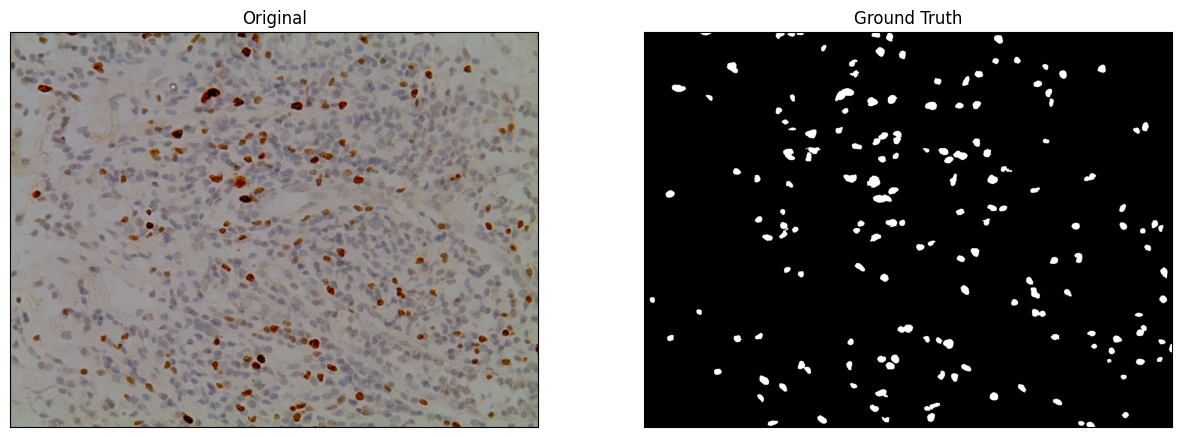

In [9]:
# Obtaining the original image and the labels
gt_imgs = [Image.open(f"{BASE_URL}/ground_truth/{name}.png") for name in no_ext_filenames]
original_imgs = [Image.open(f"{BASE_URL}/original/{name}.jpg") for name in no_ext_filenames]
visualize(original=original_imgs[0], ground_truth=gt_imgs[0])

Preparing the images to input in the model

In [10]:
input_imgs = [dt.LoadImage(f"{BASE_URL}/original/{name}.jpg")()._value / 256 for name in no_ext_filenames]

In [11]:
weights = []
detections = []
cropped_gt_imgs = []
cropped_original_imgs = []

Obtaining the predictions

In [12]:
hyperparams = {'alpha' : 0.5, 'cutoff' : 0.999}
for input_img, gt_img, original_img in zip(input_imgs, gt_imgs, original_imgs):        
        # cropping the images
        input_img = input_img[:-400, :-400]
        cropped_gt_img = crop_image(gt_img, 400)
        cropped_original_img = crop_image(original_img, 400)
        
        cropped_gt_imgs.append(cropped_gt_img)
        cropped_original_imgs.append(cropped_original_img)

        # predicting
        _,w = model.predict(input_img[np.newaxis])
        detection = model.predict_and_detect(
                input_img[np.newaxis],
                alpha=hyperparams['alpha'], 
                beta=1-hyperparams['alpha'], 
                cutoff=hyperparams['cutoff'], 
                mode="quantile"
        )[0]
        weights.append(w)
        detections.append(detection)

/home/gustavo/tcc/CellDetection-LodeSTAR/ls_veenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.pytorch, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.pytorch, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.deeplay, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.deeplay, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-11 19:50:28.191577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 238788608 exceeds 10% of free system memory.
2024-04-11 19:50:28.784594: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 238788608 exceeds 10% of free system memory.
2024-04-11 19:50:30.526439: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 59697152 exceeds 10% of free system memory.
2024-04-11 19:50:30.827169: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 119394304 exceeds 10% of free system memory.
2024-04-11 19:50:31.026402: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 119394304 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step


Visualizing the results

In [13]:
def format_output_images(input_imgs:list, detections:list,cropped_gt_imgs:list)-> tuple[list, list]:
    '''Transforms and formats the prediction into images'''
    activation_imgs = [get_activation_image(w) for w in weights]
    detection_imgs = [get_detection_image(input_img, detection) for input_img, detection in zip(input_imgs, detections)]
    # formatting the images
    activation_imgs = [activation_img.resize(gt_img.size).convert('RGB') for activation_img, gt_img in zip(activation_imgs, cropped_gt_imgs)]
    detection_imgs = [detection_img.resize(gt_img.size).convert('RGB') for detection_img, gt_img in zip(detection_imgs, cropped_gt_imgs)]
    return activation_imgs, detection_imgs


In [14]:
activation_imgs, detection_imgs = format_output_images(input_imgs, detections, cropped_gt_imgs)

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

# Evaluating the model
---

## Quantitative Evaluation
After generating all of the predictions we evaluate the model qualitatively and quantitatively.

In [15]:
total_of_images = len(activation_imgs)

### Mean IoU

Computing the mean Intersection Over Union (IOU) metric given by the following equation:
$$
 MeanIoU =\frac{1}{N}\sum_{i=1}^{N} \frac{A_i \cap B_i}{A_i \cup B_i}
$$

In [16]:
def calculate_iou(image1, image2):
    """ Computes the Intersection Over Union metric"""
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [17]:
mean_iou = sum([calculate_iou(cropped_gt_imgs[i], activation_imgs[i]) for i in range(total_of_images)]) / total_of_images
print(f'Mean IoU: {round(mean_iou, 2)}')

Mean IoU: 0.44


### Mean Dice Coheficient
Computing the mean dice Coheficient metric, given by the following equation:
$$
  Mean \space Dice = \frac{1}{N}\sum_{i=1}^{N} \frac{2 \times |A_i \cap B_i|}{|A_i|+|B_i|}
$$

In [18]:
def calculate_dice(image1, image2):
    """ Computes the Dice Coheficient metric"""
    np_1 = np.asarray(image1)
    np_2 = np.asarray(image2)
    intersection = np.sum(np_1 & np_2)
    sum = abs(np.sum(image1)) + abs(np.sum(image2))
    dice = (2. * intersection) / sum 
    return dice

In [19]:
mean_dice = sum([calculate_dice(cropped_gt_imgs[i], activation_imgs[i]) for i in range(total_of_images)]) / total_of_images
print(f'Mean Dice: {round(mean_dice, 2)}')

Mean Dice: 0.4


## Qualitative Evaluation
We also evaluate the model qualitatively. That is, visually assessing the overlap between what was predicted and what actually should have been.

In [20]:
def overlay_comparison(pred, gt):
    """ Creates an overlapped visualization 
    bewtween the ground truth and the obtained prediction"""
    pred_arr = np.asarray(pred)
    gt_arr = np.asarray(gt)

    binary_xor = cv2.bitwise_xor(pred_arr, gt_arr)
    return Image.fromarray(binary_xor)

In [21]:
def change_color(img):
    ''' Transforms all the white color in green'''
    green = np.array([0, 255, 0])
    # Definir as cores que você quer substituir (branco)
    low = np.array([200, 200, 200])
    high = np.array([255, 255, 255])
    mask = cv2.inRange(np.array(img), low, high)
    painted_img = np.array(img).copy()
    # Substituir as cores brancas pela cor verde
    painted_img[mask != 0] = green
    return painted_img

In pink we can visualize the overlapping between the predicted wheights (in green) and the ground truth (in white). 

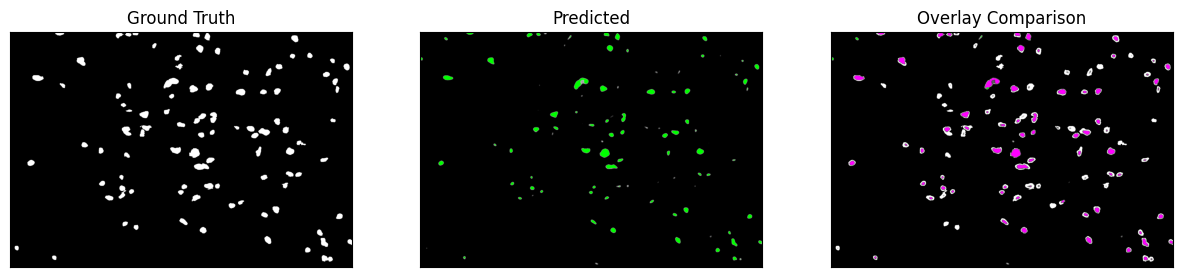

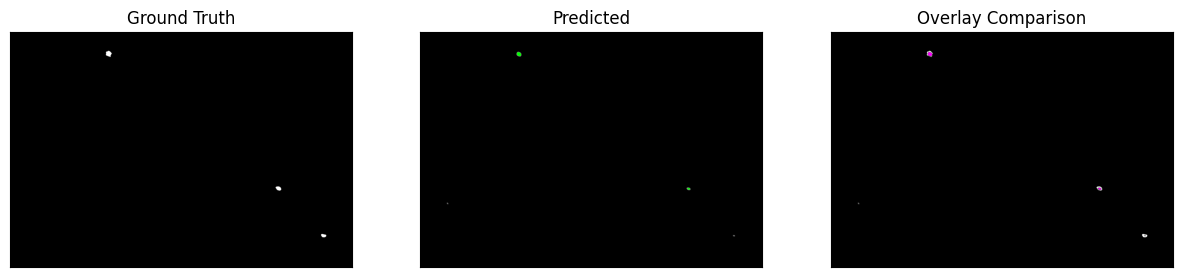

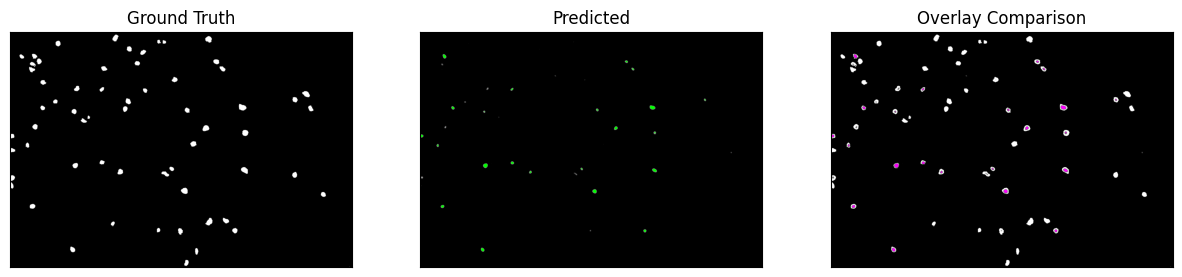

In [22]:
for index in range(0,3):
    ovl_img = overlay_comparison(change_color(activation_imgs[index]), cropped_gt_imgs[index])
    visualize(ground_truth=cropped_gt_imgs[index], predicted=change_color(activation_imgs[index]), overlay_comparison=ovl_img)

# Saving the results
---

In [25]:
RESULT_FOLDER = f'../../out/LodeStar/{datetime.datetime.now()}'

def save_results(original_imgs, activation_imgs, detection_imgs, gt_imgs):  
    """ Saves all of the predicionts to the output folder """
    # Creates the output folder if does not exists
    if not os.path.exists(RESULT_FOLDER):
        os.makedirs(RESULT_FOLDER)
        os.makedirs(f'{RESULT_FOLDER}/activation_imgs')
        os.makedirs(f'{RESULT_FOLDER}/detection_imgs')
        os.makedirs(f'{RESULT_FOLDER}/original')
        os.makedirs(f'{RESULT_FOLDER}/cropped_gt')
    # Saves each file on the respective folder
    for i in range(len(original_imgs)):
            activation_imgs[i].save(f'{RESULT_FOLDER}/activation_imgs/{i+1}.jpg')
            detection_imgs[i].save(f'{RESULT_FOLDER}/detection_imgs/{i+1}.jpg')
            original_imgs[i].save(f'{RESULT_FOLDER}/original/{i+1}.jpg')
            gt_imgs[i].save(f'{RESULT_FOLDER}/cropped_gt/{i+1}.jpg')

In [26]:
save_results(cropped_original_imgs, cropped_gt_imgs, detection_imgs, activation_imgs)